In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_samples, silhouette_score

import sys
sys.path.insert(0, '../LaurieOnTracking')
import Metrica_Viz as mviz
import Metrica_IO as mio


In [57]:
# set up initial path to data
DATADIR = '../sample-data-master/data'
game_id = 2 # let's look at sample match 2

# read in the event data
events = mio.read_event_data(DATADIR,game_id)

# Bit of housekeeping: unit conversion from metric data units to meters
events = mio.to_metric_coordinates(events)
events.head()
#### TRACKING DATA ####

# READING IN TRACKING DATA
tracking_home = mio.tracking_data(DATADIR,game_id,'Home')
tracking_away = mio.tracking_data(DATADIR,game_id,'Away')
# Look at the column namems
print( tracking_home.columns )
# Convert positions from metrica units to meters 
tracking_home = mio.to_metric_coordinates(tracking_home)
tracking_away = mio.to_metric_coordinates(tracking_away)
# reverse direction of play in the second half so that home team is always attacking from right->left
tracking_home,tracking_away,events = mio.to_single_playing_direction(tracking_home,tracking_away,events)
# add velocities
#tracking_home = mvel.calc_player_velocities(tracking_home,smoothing=True)

Reading team: home
Reading team: away
Index(['Period', 'Time [s]', 'Home_11_x', 'Home_11_y', 'Home_1_x', 'Home_1_y',
       'Home_2_x', 'Home_2_y', 'Home_3_x', 'Home_3_y', 'Home_4_x', 'Home_4_y',
       'Home_5_x', 'Home_5_y', 'Home_6_x', 'Home_6_y', 'Home_7_x', 'Home_7_y',
       'Home_8_x', 'Home_8_y', 'Home_9_x', 'Home_9_y', 'Home_10_x',
       'Home_10_y', 'Home_12_x', 'Home_12_y', 'Home_13_x', 'Home_13_y',
       'Home_14_x', 'Home_14_y', 'ball_x', 'ball_y'],
      dtype='object')


In [58]:
# explore on dimensional features
data = pd.read_csv('.././results/metrica_1_query_features.csv', sep=';')
data = data.set_index([data.frame])
data.head()

,frame,ball x,ball y,ball velocity,inside,zone,centroid x_home,centroid y_home,centroid_zone_home,rest defence_home,...,team distance_home,centroid x_away,centroid y_away,centroid_zone_away,rest defence_away,width_away,length_away,occupancy map_away,team distance_away,close to ball
frame,,,,,,,,,,,,,,,,,,,,,
1,1,-4.210850,-7.976468,NaN,True,8.0,10.094571,-5.163961,11.0,9.0,...,8.680589,-2.246204,-1.267493,8.0,5.0,60.867956,31.771274,"[0, 1, 0, 0, 2, 4, 1, 2]",9.028938,Home
11,11,-7.553878,-17.627436,28.560805,True,9.0,10.047931,-6.105054,11.0,10.0,...,9.702955,-1.672288,-1.857080,8.0,3.0,61.266504,32.389466,"[0, 0, 0, 1, 3, 6, 0, 0]",10.760712,Away
21,21,-7.182348,-20.427676,2.905701,True,9.0,10.163927,-7.137878,11.0,10.0,...,9.245416,-0.973833,-2.569088,8.0,2.0,61.505456,33.046666,"[1, 0, 0, 0, 3, 6, 0, 0]",10.939565,Away
31,31,-6.145138,-20.814868,2.765478,True,9.0,10.325661,-8.100731,11.0,10.0,...,8.189947,-0.236465,-3.244396,8.0,3.0,61.649412,33.450950,"[1, 0, 0, 0, 3, 6, 0, 0]",10.681626,Away
41,41,-4.389248,-20.411492,2.537699,True,9.0,10.513568,-8.882724,11.0,10.0,...,6.951939,0.526809,-3.826360,11.0,4.0,61.650500,33.563098,"[0, 0, 1, 0, 3, 6, 0, 0]",9.918641,Away


In [59]:
# Ball posessions
data['close to ball'] = np.where((pd.isnull(data['ball velocity'])) |(data['ball velocity']== 0) | (pd.isnull(data['close to ball']))
                                           , "Out", data['close to ball'])
#
event = data['close to ball']
values = [event, event.shift(-1), event.shift(-2), event.shift(-3), event.shift(-4), event.shift(-5)]
sequence = np.all([v == values[0] for v in values], axis=0)
#[event[x]= np.where(sequence[x], event[x], event[x-1]) for x in range(1, len(event))]
possession = []
value = 'Out'
# loop through possession, is 5 in a row change,
for x in range(len(event)):
    if sequence[x]:
        value = event.iloc[x]
    elif value == 'Out': #changes when ball out or set piece
        value=event.iloc[x]
    possession.append(value)


In [60]:
# remove columns to prevent correlation > 0.7-
print(data.corr().unstack().sort_values().drop_duplicates().sort_values(ascending = False).head(20))
df = data.drop(columns=['frame','inside', 'close to ball', 'centroid x_away', 'zone', 'centroid_zone_home', 'centroid_zone_away', 'team distance_home',
                       'centroid y_home', 'centroid x_home', 'centroid y_away', 'occupancy map_home', 'occupancy map_away'])

print(df.corr().unstack().sort_values().drop_duplicates().sort_values(ascending = False).head(20))
df.head()

frame               frame                 1.000000
centroid x_away     centroid x_home       0.983688
ball x              zone                  0.961348
centroid x_away     centroid_zone_away    0.960948
centroid_zone_home  centroid x_home       0.958851
centroid x_away     centroid_zone_home    0.946585
centroid x_home     centroid_zone_away    0.941484
team distance_home  team distance_away    0.916728
centroid_zone_away  centroid_zone_home    0.895705
centroid y_home     centroid y_away       0.890972
centroid x_away     ball x                0.820920
ball x              centroid x_home       0.812982
centroid x_away     zone                  0.801899
centroid x_home     zone                  0.799012
ball x              centroid_zone_away    0.788660
centroid_zone_away  zone                  0.784399
centroid_zone_home  ball x                0.778517
centroid y_home     ball y                0.777109
ball y              centroid y_away       0.771656
zone                centroid_zo

,ball x,ball y,ball velocity,rest defence_home,width_home,length_home,rest defence_away,width_away,length_away,team distance_away
frame,,,,,,,,,,
1,-4.210850,-7.976468,NaN,9.0,35.080860,25.738920,5.0,60.867956,31.771274,9.028938
11,-7.553878,-17.627436,28.560805,10.0,35.327700,25.332834,3.0,61.266504,32.389466,10.760712
21,-7.182348,-20.427676,2.905701,10.0,35.427388,24.643622,2.0,61.505456,33.046666,10.939565
31,-6.145138,-20.814868,2.765478,10.0,35.446836,23.920172,3.0,61.649412,33.450950,10.681626
41,-4.389248,-20.411492,2.537699,10.0,35.345652,23.087542,4.0,61.650500,33.563098,9.918641


In [61]:
print(df.shape[0])
df = df.dropna()
print(df.shape[0])


# standardizing the data
scaler = StandardScaler()
data_scaled = scaler.fit_transform(df)

# statistics of scaled data
pd.DataFrame(data_scaled).describe()



14501
8798


,0,1,2,3,4,5,6,7,8,9
count,8.798000e+03,8.798000e+03,8.798000e+03,8.798000e+03,8.798000e+03,8.798000e+03,8.798000e+03,8.798000e+03,8.798000e+03,8.798000e+03
mean,2.584379e-17,6.460948e-18,5.814853e-17,5.814853e-17,4.070397e-16,3.472759e-16,9.691422e-18,3.747350e-16,-2.972036e-16,-4.684187e-17
std,1.000057e+00,1.000057e+00,1.000057e+00,1.000057e+00,1.000057e+00,1.000057e+00,1.000057e+00,1.000057e+00,1.000057e+00,1.000057e+00
min,-2.360879e+00,-2.037539e+00,-1.178140e+00,-1.922523e+00,-3.019920e+00,-2.544449e+00,-1.795780e+00,-2.861312e+00,-3.061626e+00,-2.046683e+00
25%,-6.833627e-01,-8.452119e-01,-8.335883e-01,-6.338838e-01,-7.699843e-01,-6.941675e-01,-8.297983e-01,-6.849839e-01,-5.650851e-01,-7.108252e-01
50%,-1.371226e-02,4.256733e-02,-2.837027e-01,1.043596e-02,-1.855159e-01,-3.159919e-02,1.361831e-01,-1.058901e-01,-1.575184e-02,-1.401990e-01
75%,7.248705e-01,8.342821e-01,6.967638e-01,6.547558e-01,7.418927e-01,6.313779e-01,7.801707e-01,6.692928e-01,6.130731e-01,5.897958e-01
max,2.102715e+00,1.810370e+00,7.488908e+00,1.299076e+00,2.690034e+00,4.631017e+00,1.424158e+00,2.288626e+00,3.236451e+00,3.955293e+00


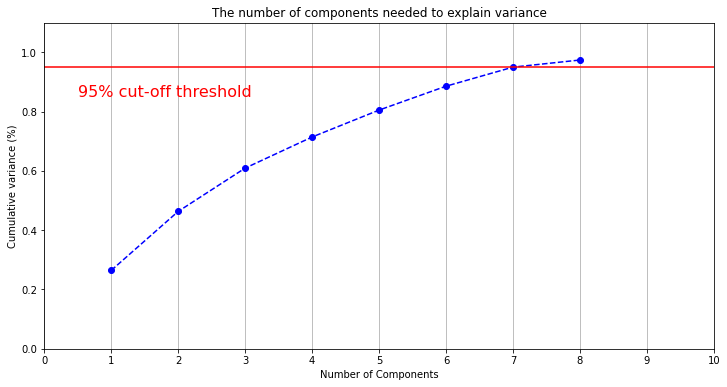

In [62]:
pca = PCA(n_components = 0.95)
pca.fit(data_scaled)
reduced = pca.transform(data_scaled)

#% matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (12,6)

fig, ax = plt.subplots()
xi = np.arange(1, 9, step=1)
y = np.cumsum(pca.explained_variance_ratio_)

plt.ylim(0.0,1.1)
plt.plot(xi, y, marker='o', linestyle='--', color='b')

plt.xlabel('Number of Components')
plt.xticks(np.arange(0, 11, step=1)) #change from 0-based array index to 1-based human-readable label
plt.ylabel('Cumulative variance (%)')
plt.title('The number of components needed to explain variance')

plt.axhline(y=0.95, color='r', linestyle='-')
plt.text(0.5, 0.85, '95% cut-off threshold', color = 'red', fontsize=16)

ax.grid(axis='x')
plt.show()
PCA_components = pd.DataFrame(reduced)
PCA_components.index= df.index

In [63]:
possession = pd.DataFrame(possession, columns=['possession'])
possession

,possession
0,Out
1,Away
2,Away
3,Away
4,Away
...,...
14496,Out
14497,Out
14498,Out
14499,Out


In [64]:
# Query / filter the data on possession
possession = pd.DataFrame(possession, columns=['possession'])
possession_agg= possession.groupby('possession').agg(
    Count=('possession', 'count'),
    #avg_duration = ('Duration_frames', 'mean'),
    #sum_duration = ('Duration_frames', 'sum')
)
#possession_agg.avg_duration = possession_agg.avg_duration/25
#possession_agg.sum_duration = possession_agg.sum_duration/25
#possession_agg['percentage']= possession_agg['sum_duration']/possession_agg['sum_duration'].sum()
possession_agg.head()

,Count
possession,
Away,3787
Home,4122
Out,6592


In [ ]:
"""
possession = pd.read_csv('.././results/phases_game_2_Event.csv', sep=',')
possession.Team = possession.Team.fillna("NaN")
possession_agg= possession.groupby('Team').agg(
    Count=('Team', 'count'),
    avg_duration = ('Duration_frames', 'mean'),
    sum_duration = ('Duration_frames', 'sum')
)
possession_agg.avg_duration = possession_agg.avg_duration/25
possession_agg.sum_duration = possession_agg.sum_duration/25
possession_agg['percentage']= possession_agg['sum_duration']/possession_agg['sum_duration'].sum()
possession_agg.head()
"""

In [ ]:
# real filtering on possession
possession_home = possession[possession.Team =='Home']
# check if start frame is in home possession 
start_frames = PCA_components.index.values
start_frame_in_possession = [any([(start_frame in value) for value in possession_home['period']]) 
                             for start_frame in start_frames]
end_frames= PCA_components.index.values + 499
end_frame_in_possession = [any([(end_frame in value) for value in possession_home['period']]) 
                             for end_frame in end_frames]
# Both have to be true
fragments_in_home = [all(tup) for tup in zip(start_frame_in_possession, end_frame_in_possession)]
# filter data
print(PCA_components.shape[0])
PCA_components = PCA_components[fragments_in_home]
print(PCA_components.shape[0])

In [ ]:

# remove ball related columns
#df = df.drop(columns=['ball distance netto x', 'ball distance netto y', 'ball distance trajectory', 'rest defence_home', 'rest defence_away'])
# alternatively remove nans



# preprocessing
df.describe()
PCA_components[0]


In [ ]:
# fitting multiple k-means algorithms and storing the values in an empty list
SSE = []
for cluster in range(1,20):
    kmeans = KMeans(n_jobs = -1, n_clusters = cluster, init='k-means++')
    kmeans.fit(PCA_components)
    SSE.append(kmeans.inertia_)

# converting the results into a dataframe and plotting them
frame = pd.DataFrame({'Cluster':range(1,20), 'SSE':SSE})
plt.figure(figsize=(12,6))
plt.plot(frame['Cluster'], frame['SSE'], marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')

In [ ]:
for i, k in enumerate([2,3, 4, 5, 6]):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)
    
    # Run the Kmeans algorithm
    km = KMeans(n_clusters=k)
    labels = km.fit_predict(PCA_components)
    centroids = km.cluster_centers_

    # Get silhouette samples
    silhouette_vals = silhouette_samples(PCA_components, labels)

    # Silhouette plot
    y_ticks = []
    y_lower, y_upper = 0, 0
    for i, cluster in enumerate(np.unique(labels)):
        cluster_silhouette_vals = silhouette_vals[labels == cluster]
        cluster_silhouette_vals.sort()
        y_upper += len(cluster_silhouette_vals)
        ax1.barh(range(y_lower, y_upper), cluster_silhouette_vals, edgecolor='none', height=1)
        ax1.text(-0.03, (y_lower + y_upper) / 2, str(i + 1))
        y_lower += len(cluster_silhouette_vals)

    # Get the average silhouette score and plot it
    avg_score = np.mean(silhouette_vals)
    ax1.axvline(avg_score, linestyle='--', linewidth=2, color='green')
    ax1.set_yticks([])
    ax1.set_xlim([-0.1, 1])
    ax1.set_xlabel('Silhouette coefficient values')
    ax1.set_ylabel('Cluster labels')
    ax1.set_title('Silhouette plot for the various clusters', y=1.02);
    
    # Scatter plot of data colored with labels
    #ax2.scatter(PCA_components[:, 0], PCA_components[:, 1], c=labels)
    ax2.scatter(centroids[:, 0], centroids[:, 1], marker='*', c='r', s=250)
    ax2.set_xlim([-2, 2])
    ax2.set_xlim([-2, 2])
    ax2.set_xlabel('Eruption time in mins')
    ax2.set_ylabel('Waiting time to next eruption')
    ax2.set_title('Visualization of clustered data', y=1.02)
    ax2.set_aspect('equal')
    plt.tight_layout()
    plt.suptitle(f'Silhouette analysis using k = {k}',
                 fontsize=16, fontweight='semibold', y=1.05);

In [ ]:
kmeans = KMeans(n_jobs = -1, n_clusters = 5, init='k-means++')
kmeans.fit(PCA_components)
pred = kmeans.predict(PCA_components)

frame = pd.DataFrame(PCA_components)
frame =frame.set_index([PCA_components.index])
frame['cluster'] = pred
frame['cluster'].value_counts()


In [ ]:
import scipy.cluster.hierarchy as sch
X = PCA_components
plt.figure()
dendrogram = sch.dendrogram(sch.linkage(X, method='ward'))
plt.show()
# so 7 clusters

In [ ]:
import time
from sklearn.cluster import AgglomerativeClustering
from sklearn.neighbors import kneighbors_graph

# Create meanshift object
clt = AgglomerativeClustering(linkage='complete', 
                              affinity='euclidean', 
                              n_clusters=8)

# Train model
model = clt.fit(PCA_components)

In [ ]:
import scipy.cluster.hierarchy as sch
import sklearn.cluster as cluster
import seaborn as sns
data = PCA_components
%matplotlib inline
sns.set_context('poster')
sns.set_color_codes()
plot_kwds = {'alpha' : 0.25, 's' : 80, 'linewidths':0}
def plot_clusters(data, algorithm, args, kwds):
    start_time = time.time()
    labels = algorithm(*args, **kwds).fit_predict(data)
    end_time = time.time()
    palette = sns.color_palette('deep', np.unique(labels).max() + 1)
    colors = [palette[x] if x >= 0 else (0.0, 0.0, 0.0) for x in labels]
    plt.scatter(data[0], data[1], c=colors, **plot_kwds)
    frame = plt.gca()
    frame.axes.get_xaxis().set_visible(False)
    frame.axes.get_yaxis().set_visible(False)
    plt.title('Clusters found by {}'.format(str(algorithm.__name__)), fontsize=24)
    plt.text(-0.5, 0.7, 'Clustering took {:.2f} s'.format(end_time - start_time), fontsize=14)
    
plot_clusters(data, cluster.KMeans, (), {'n_clusters':7})
plot_clusters(data, cluster.AffinityPropagation, (), {'preference':-5.0, 'damping':0.95})
plot_clusters(data, cluster.MeanShift, (0.175,), {'cluster_all':False})
plot_clusters(data, cluster.SpectralClustering, (), {'n_clusters':6})
plot_clusters(data, cluster.AgglomerativeClustering, (), {'n_clusters':6, 'linkage':'ward'})
plot_clusters(data, cluster.DBSCAN, (), {'eps':0.025})
import hdbscan
plot_clusters(data, hdbscan.HDBSCAN, (), {'min_cluster_size':15})
